# GroupMe Data Scraping

## To download your GroupMe data, go to your GroupMe profile on the web version.  Click on "Export My Data", then "Create Export".  You can choose which groups and/or direct messages to export.  The data I used for information about likes is in the message.json file.

In [1]:
import pandas as pd

df = pd.read_json('message_physics_trauma.json')

df['like_num'] = df['favorited_by'].apply(len)
df.head()
name_pivtab = pd.pivot_table(df,index='sender_id',columns='name',aggfunc='count').fillna(0)

def get_max_name(s):
    if s in name_pivtab.T:
        return name_pivtab.T[s].idxmax()[1]
    else:
        return s
df['Name'] = df['sender_id'].apply(get_max_name)

df_likes = df.groupby('Name')['like_num'].agg('sum').sort_values(ascending = False)

df_likes = pd.DataFrame(df_likes)
df_likes

,like_num
Name,
Guillermo Suarez,522
Tau Neutrino Tommy,492
Dan Le,438
Dabiano Peruana,255
Nolan King,227
"Dwayne ""Dirac"" Johnson",215
Raj Patel,180
Austen Adams,155
DiPaul Moment,124


### Now that we have the number of likes received, we can figure out the number of likes given and compare them.

In [2]:
def get_max_name_list(l):
    l_new=list()
    for s in l:
        l_new.append(get_max_name(s))
    return l_new
df['liked_by_names'] = df['favorited_by'].apply(get_max_name_list)
df['liked_by_names']
liked_series = df[df['like_num']>0]
liked_series['liked_by_names']

id_name_dict = {}
for sender_id in df['sender_id'].unique():
    id_name_dict[sender_id] = get_max_name(sender_id)
    


In [3]:
df_likes_given = df.groupby('Name')['created_at'].agg('count')
df_likes_given = pd.DataFrame(df_likes_given)

def likes_given(s):
    return sum([1*(s in name) for name in liked_series['liked_by_names']])


df_likes_given['Name'] = df_likes_given.index.values
df_likes_given['likes_given'] = df_likes_given['Name'].apply(likes_given)
df_likes_given = df_likes_given.drop('Name',axis=1)


In [4]:
df_likes_proportion = pd.merge(df_likes_given,df_likes,left_on = 'Name',right_on = 'Name')
df_likes_proportion = df_likes_proportion.rename(columns = {'created_at':'messages','like_num':'likes'})
df_likes_proportion['likes_per_messages'] = df_likes_proportion['likes']/df_likes_proportion['messages']
df_likes_proportion['likes_per_messages'].sort_values(ascending=False)
df_likes_proportion['ratio_of_received_to_given'] = df_likes_proportion['likes']/df_likes_proportion['likes_given']
df_likes_proportion = df_likes_proportion.sort_values(by = 'likes', ascending = False)


### A quick scatterplot shows that the number of likes given and likes received tends to be positively correlated, indicating that group members that are active in the chat both like messages and have their messages liked.

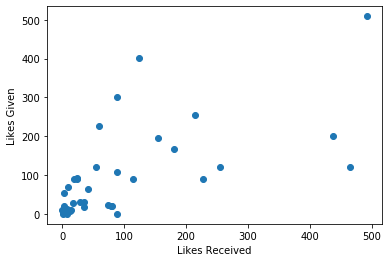

In [12]:
import matplotlib.pyplot as plt
plt.scatter(df_likes_proportion['likes'],df_likes_proportion['likes_given'])
plt.xlabel('Likes Received')
plt.ylabel('Likes Given')
plt.show()

### This code creates a "biggest fan" attribute, which determines who has liked the most of each person's messages.

In [6]:
import numpy as np
liked_df_group = liked_series.groupby('Name')

def get_likes_in_group(s, name):
    return sum([1*(name in group) for group in np.array(liked_df_group.get_group(s)['liked_by_names'])])
def get_favorites(s):
    if s in list(liked_series['Name']):
        liked_by_array = np.array(liked_df_group.get_group(s)['liked_by_names'])
        names_list = list()
        num_messages_liked = list()
        for name in df_likes_proportion.index.values:
            names_list.append(name)
            num_messages_liked.append(get_likes_in_group(s,name))
        index = pd.Series(num_messages_liked).idxmax()
        return (names_list[index], int(num_messages_liked[index]))
    else:
        return ''
df_likes_proportion['Name'] = df_likes_proportion.index.values
df_likes_proportion['biggest_fan'] = df_likes_proportion['Name'].apply(get_favorites)
df_likes_proportion = df_likes_proportion.drop('Name',axis=1)


### List the top 3 most-liked messages

In [7]:
df['Likes'] = df['favorited_by'].map(len)
df.sort_values(by='Likes', ascending = False)[:3]

,attachments,avatar_url,created_at,event,favorited_by,group_id,id,name,platform,sender_id,sender_type,source_guid,system,text,user_id,like_num,Name,liked_by_names,Likes
1723,"[{'type': 'image', 'url': 'https://i.groupme.c...",https://i.groupme.com/748x750.jpeg.91453069ffa...,2018-12-11 18:47:39,NaN,"[10422302, 13252036, 13591321, 18051097, 18431...",42984966,154455405949959872,Jacob Davis,NaN,22188271,user,FA55704C-5C02-4BFE-9A0B-B82072D6D8E5,False,None,22188271,17,Jacob Davis,"[Gavin Rubin, Alex Towler, Dabiano Peruana, Sh...",17
2756,"[{'type': 'image', 'url': 'https://i.groupme.c...",https://i.groupme.com/720x722.jpeg.9d213a65f8c...,2018-09-18 19:32:00,NaN,"[13252036, 18051097, 18431824, 20536662, 22188...",42984966,153729912065922336,Guillermo Suarez,NaN,30195926,user,B0013E96-0BAF-48F1-ACC9-2903E6E73381,False,None,30195926,15,Guillermo Suarez,"[Alex Towler, Shadnus Karlsen, Austen Adams, B...",15
192,"[{'loci': [[0, 17], [18, 7]], 'type': 'mention...",https://i.groupme.com/720x1280.jpeg.2095132e71...,2019-05-16 21:51:18,NaN,"[18085666, 18431824, 20536662, 22995449, 24658...",42984966,155804347820115552,Tau Neutrino Tommy,gm,34785596,user,android-94a89e2a-d129-48dd-8b43-223a9d2da3e9,False,@Guillermo Suarez @John H,34785596,15,Tau Neutrino Tommy,"[Juantum Physics, Austen Adams, Bobby Fischer,...",15


### Find the person who is the biggest fan of the most people.  The commented code allows you to reverse search for fans- in other words, who are the people for whom "Insert Name Here" is their biggest fan?

In [8]:
def get_name(s):
    if(len(s)>0):
        return s[0]
    else:
        return None

    
df_likes_proportion['biggest_fan'].map(get_name).value_counts().dropna()
#If you want to find instances where the biggest fan has a certain name:
#df_likes_proportion['fan_name'] = df_likes_proportion['biggest_fan'].map(get_name)
#df_likes_proportion['fan_name'].value_counts().dropna()
#df_likes_proportion[df_likes_proportion['fan_name']=='Insert Name']

Tau Neutrino Tommy        17
DiPaul Moment              7
Dwayne "Dirac" Johnson     6
Charm Quark Chels          4
Dabiano Peruana            2
Dan Le                     1
Bobby Fischer              1
Name: biggest_fan, dtype: int64

### Finds messages where the sender liked their own messages, and counts how many times each sender has done this.

In [9]:
def self_liked(likers, sender):
    for user in likers:
        if user == sender:
            return 1
    return 0
   
    
df['self_liked'] = df.apply(lambda x: self_liked(x['favorited_by'], x['sender_id']), axis=1)
self_liked = df[df['self_liked']==1]
print('Number of self likes:')
self_liked['Name'].value_counts()

Number of self likes:


Guillermo Suarez    57
Shadnus Karlsen      1
Name: Name, dtype: int64

### By popular request, a self like-to-like ratio

In [10]:
self_like_list = self_liked['Name'].value_counts()
def self_like_merge(s):
    if s in self_like_list:
        return self_like_list[s]
    else:
        return 0
df_likes_proportion['self_likes'] = df_likes_proportion.index.map(self_like_merge)
df_likes_proportion['self_likes_ratio'] = df_likes_proportion['self_likes'] / df_likes_proportion['likes']
df_self_likes_ratio = pd.DataFrame(df_likes_proportion['self_likes_ratio'])
df_self_likes_ratio[df_self_likes_ratio['self_likes_ratio']>0].sort_values(by='self_likes_ratio',ascending=False)

,self_likes_ratio
Name,
Guillermo Suarez,0.109195
Shadnus Karlsen,0.023256


### Here's the final table.  I've subtracted the self-likes from the total likes since they don't count!

In [11]:
df_likes_proportion['likes'] = df_likes_proportion['likes'] - df_likes_proportion['self_likes']
df_likes_proportion['likes_per_messages'] = df_likes_proportion['likes']/df_likes_proportion['messages']
df_likes_proportion.sort_values(by='likes', ascending=False)

,messages,likes_given,likes,likes_per_messages,ratio_of_received_to_given,biggest_fan,self_likes,self_likes_ratio
Name,,,,,,,,
Tau Neutrino Tommy,313,509,492,1.571885,0.966601,"(DiPaul Moment, 78)",0,0.000000
Guillermo Suarez,317,120,465,1.466877,4.350000,"(Tau Neutrino Tommy, 80)",57,0.109195
Dan Le,561,201,438,0.780749,2.179104,"(DiPaul Moment, 71)",0,0.000000
Dabiano Peruana,146,122,255,1.746575,2.090164,"(Tau Neutrino Tommy, 43)",0,0.000000
Nolan King,135,89,227,1.681481,2.550562,"(Charm Quark Chels, 38)",0,0.000000
"Dwayne ""Dirac"" Johnson",306,254,215,0.702614,0.846457,"(Tau Neutrino Tommy, 42)",0,0.000000
Raj Patel,256,166,180,0.703125,1.084337,"(DiPaul Moment, 43)",0,0.000000
Austen Adams,65,195,155,2.384615,0.794872,"(Tau Neutrino Tommy, 19)",0,0.000000
DiPaul Moment,124,401,124,1.000000,0.309227,"(Tau Neutrino Tommy, 27)",0,0.000000
